**Работа на реальных данных**

# Импорт библиотек и классов

In [221]:
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import pandas as pd # Библиотека Pandas для работы с табличными данными


from sklearn.preprocessing import StandardScaler
import sklearn.datasets as ds

from sklearn import preprocessing as prep

from sklearn.metrics import silhouette_samples # функция scikit-learn для оценки Коэффициента Силлуэта
from sklearn.preprocessing import PowerTransformer  # Степенное преобразование от scikit-learn

import seaborn as sns# библиотека Seaborn для визуализации данных из Pandas

import matplotlib # библиотека Matplotlib для визуализации
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
# по разному импортируем потому что в модуле pyplot много рисования (и удобней сократить при применении),
# но нам понадобится ещё кое-что из matplotlib

from sklearn.cluster import KMeans # Кластеризация К-Средних от scikit-learn

# предварительная обработка числовых признаков
from sklearn.preprocessing import MinMaxScaler# Импортируем нормализацию от scikit-learn
from sklearn.preprocessing import StandardScaler # Импортируем стандартизацию от scikit-learn
from sklearn.preprocessing import PowerTransformer  # Степенное преобразование от scikit-learn
# предварительная обработка категориальных признаков
from sklearn.preprocessing import OneHotEncoder# Импортируем One-Hot Encoding от scikit-learn
from sklearn.preprocessing import OrdinalEncoder# Импортируем Порядковое кодированиеот scikit-learn
from sklearn.preprocessing import LabelEncoder# Импортируем LabelEncoder от scikit-learn

from sklearn.pipeline import Pipeline # Pipeline.Не добавить, не убавить

from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок

from sklearn.base import BaseEstimator, TransformerMixin # для создания собственных преобразователей / трансформеров данных

In [222]:
def plot_silhouette_results(X,centroids,labels, label_centroids, axis_x, axis_y):
    """Визуализация результатов кластеризации и коэффициентов силуэта
    Входные переменные:
    ===========
    X: признаки
    centroids: центры кластеров
    labels: метки кластеров для данных
    centroids: метки центров кластеров
    axis_x: какую ось рисовать в качестве Х
    axis_y: какую ось рисовать в качестве У
    """

    # создаем большое полотно
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(25  , 5)

    # считаем коэффициенты силуэта через функцию scikit-learn
    silhouette_vals = silhouette_samples(X, labels)

    # выбираем цветовую карту - мне нравится 'bwr'
    cmap = matplotlib.colormaps['bwr']
    y_lower, y_upper = 0, 0
    # перебираем все метки кластеров
    for i, cluster in enumerate(np.unique(labels)):
        # отбираем коэффициент силуэта для текущей метки
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        # сортируем
        cluster_silhouette_vals.sort()

        # визуализируем
        # определяем верхнюю границу рисования (по вертикали
        y_upper += len(cluster_silhouette_vals)  # как количество объектов с текущей меткой
        c = cluster /max(labels) # считаем "координату" метки кластера в цветовой карте
        # с помощью горизонтальных полос визуализируем коэффициенты силуэта
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals,color = cmap(c), edgecolor='none', height=1)
        # "слева" напишем номер метки кластеров
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        # переопределим нижнюю границу рисования  (по вертикали)
        y_lower += len(cluster_silhouette_vals)  # (предыдущая верхняя граница)

    # оцениваем среднее значение коэффициента силлуэта
    avg_score = np.mean(silhouette_vals)
    # визуализируем через вертикальную линию
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Коэффициент Силуэта')
    ax1.set_ylabel('Кластеры')


    # визуализируем данные с подракашиванием
    # сначала сами данные
    ax2.scatter(X[:, axis_x], X[:, axis_y], c=labels, alpha = 0.7,  cmap = 'bwr',)
    # а потом центры кластеров, но большими кругами
    ax2.scatter(centroids[:, axis_x], centroids[:, axis_y], c=label_centroids, cmap = 'bwr', edgecolors = 'k', s=400)
    ax2.set_xlabel(axis_x)
    ax2.set_ylabel(axis_y)
    ax2.set_aspect('equal')
    plt.tight_layout();

In [223]:
def plot_multi(data, y,  names, sub, size, edgecolors = 'none', alpha = 0.5):
    axis = [[0,1],
            [2,1],
            [0,3],
            [2,3],]


    labels = [['',names[1]],
            ['',''],
            [names[0],names[3]],
            [names[2],'']]



    for n, (axi, label, ax) in enumerate(zip(axis,  labels, sub.flatten())):
        scatter = ax.scatter(data[:,axi[0]],data[:,axi[1]],
                             c=y, s = size, cmap = 'bwr',
                             alpha = alpha, facecolors = 'none' ,
                             linewidths = 2,
                             edgecolors = edgecolors);
        ax.set_ylabel(label[1], fontsize = 20)
        ax.set_xlabel(label[0], fontsize = 20)
        ax.tick_params(axis='x', labelsize= 15)
        ax.tick_params(axis='y', labelsize= 15)
        ax.grid()
        legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper left", title="Clusters",
                        fontsize = 15)
        ax.add_artist(legend1)

In [224]:
def plot_cluster(X,centroids, cluster_label, centroids_label, old_centroids = None, old_centroids_label = None):
    """Визуализация кластера
    Входные переменные:
    ===========
    X: признаки
    centroids: текущие центры кластеров
    cluster_label: метки кластеров для признаков
    centroids_label: метки для текущих центров кластеров
    old_centroids: предыдущие центры кластеров
    old_centroids_label: метки для предыдущих центров кластеров
    """
    fig = plt.figure(figsize=(11,10)) # Создаем полотно
    # Визуализируем наши признаки
    plt.scatter(X[:, 0], X[:, 1],
                c = cluster_label, cmap = 'bwr',
                s=100,alpha = 0.3)
    # Визуализируем текущие центры кластеров. Как точки, но побольше
    plt.scatter(centroids[:, 0], centroids[:, 1],
                c = centroids_label, cmap = 'bwr',
                s=400, edgecolors = 'w')

    if old_centroids is not None: # если хотим визуализировать предыдущие центры кластеров
        # их отрисуем поменьше, чем текущие центры, но больше чем "рядовые точки"
        plt.scatter(old_centroids[:, 0], old_centroids[:, 1],
            c = old_centroids_label, cmap = 'bwr',
            s=200, edgecolors = 'w')

    plt.xticks([])
    plt.yticks([])

In [225]:
plt.style.use('dark_background')

# Набор данных



**Предсказание цены на дом**

Набор данных представляет собой 1460 строк и 79 переменных, описывающих (почти) каждый аспект жилых домов в Эймсе, штат Айова.

С помощью этого датасета решается задача регрессии - предсказать окончательную стоимость дома (перменная SalePrice).

Наша цель - увидеть, как те или иные признаки влияют на стоимость дома, а также их взаимосвязь друг с другом.

Обычно в этом датасете я выбирала по 5 самых интересующих меня категориальных и числовых признаков для будующей работы. В этот раз я сохраню 5 интересующих меня категориальных признаков и выберу все числовые.


*Выбранные категориальные признаки:*

Street (тип дороги, ведущей к участку)

Utilities (тип доступных коммунальных услуг)

LotConfig (конфигурация участка)

Condition1 (близость к различным условиям)

RoofStyle (тип крыши)

Нашей целевой переменной станет категориальный признак LotConfig

In [226]:
df = pd.read_csv('https://raw.githubusercontent.com/dariaValerievna/Analytics/refs/heads/dariaValerievna-homework-1/train.csv', delimiter = ',') # считываем файл из интернета
df #выведем DataFrame

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [227]:
#Число каждого значения признака LotConfig
df['LotConfig'].value_counts()

,count
LotConfig,
Inside,1052
Corner,263
CulDSac,94
FR2,47
FR3,4


In [228]:
#удалим переменную Id, чтобы она не учитывалась за числовой признак
df = df.drop('Id', axis = 1)

In [229]:
#удаляем все столбцы, в которых присутсвует хоть одно значение Nan
df = df.dropna(axis=1)

In [230]:
#запишем выбранные признаки в новые переменные
cat_columns= ['Street', 'Utilities', 'LotConfig', 'Condition1', 'RoofStyle']

num_columns = [] # создаем пустой список для имен колонок числовых данных
for column_name in df.columns: # смотрим на все колонки в датафрейме
    if not(df[column_name].dtypes == object): # проверяем тип данных для каждой колонки
        num_columns +=[column_name] # иначе - числовые

#удаляем из датафрейма остальные признаки
df = df.drop(columns=[col for col in df.columns if (col not in cat_columns) and (col not in num_columns)])

#выведем получившийся датафрейм
df

,MSSubClass,LotArea,Street,Utilities,LotConfig,Condition1,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,8450,Pave,AllPub,Inside,Norm,7,5,2003,2003,...,0,61,0,0,0,0,0,2,2008,208500
1,20,9600,Pave,AllPub,FR2,Feedr,6,8,1976,1976,...,298,0,0,0,0,0,0,5,2007,181500
2,60,11250,Pave,AllPub,Inside,Norm,7,5,2001,2002,...,0,42,0,0,0,0,0,9,2008,223500
3,70,9550,Pave,AllPub,Corner,Norm,7,5,1915,1970,...,0,35,272,0,0,0,0,2,2006,140000
4,60,14260,Pave,AllPub,FR2,Norm,8,5,2000,2000,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,7917,Pave,AllPub,Inside,Norm,6,5,1999,2000,...,0,40,0,0,0,0,0,8,2007,175000
1456,20,13175,Pave,AllPub,Inside,Norm,6,6,1978,1988,...,349,0,0,0,0,0,0,2,2010,210000
1457,70,9042,Pave,AllPub,Inside,Norm,7,9,1941,2006,...,0,60,0,0,0,0,2500,5,2010,266500
1458,20,9717,Pave,AllPub,Inside,Norm,5,6,1950,1996,...,366,0,112,0,0,0,0,4,2010,142125


## Предварительная обработка числовых данных

**нормализация**

In [231]:
DF_Scaled  = df.copy()
Xmin = df[num_columns].min() # находим минимум (для каждого числового признака)
Xmax = df[num_columns].max() # находим максимум (для каждого числового признака)
                                                # ↓ каждый столбец делится на свою разницу максимума и минимума
DF_Scaled[num_columns] = (df[num_columns]- Xmin)/( Xmax - Xmin) # реализуем нормализацию. матричные операции работают
                                        # ↑ из каждого стобца вычитаем свой минимум

**стандартизация**

In [232]:
M = DF_Scaled[num_columns].mean() # находим среднее (для каждого числового признака)
STD = DF_Scaled[num_columns].std() # находим стандартное отклонение (для каждого числового признака)
DF_Scaled[num_columns] = (DF_Scaled[num_columns]-M)/STD # реализуем стандартизацию. матричные операции работают

**степенное преобразование**

In [233]:
pt = PowerTransformer()

pt.fit(DF_Scaled[num_columns]);

In [234]:
power = pt.transform(DF_Scaled[num_columns])
df_power = pd.DataFrame(power, columns= num_columns)
df_power

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,0.440795,-0.174051,0.677990,-0.453585,1.155965,0.913189,0.783989,-0.358785,-1.062292,-0.404380,...,-0.898385,0.763003,-0.407276,-0.129279,-0.293785,-0.069409,-0.192171,-1.690136,0.167538,0.630854
1,-1.123246,0.126308,-0.024837,1.885350,-0.008165,-0.640550,1.208522,-0.358785,-0.591673,0.559545,...,1.486226,-0.984121,-0.407276,-0.129279,-0.293785,-0.069409,-0.192171,-0.454881,-0.598633,0.282396
2,0.440795,0.488867,0.677990,-0.453585,1.059203,0.837622,0.347860,-0.358785,-0.127042,-0.236307,...,-0.898385,0.410286,-0.407276,-0.129279,-0.293785,-0.069409,-0.192171,0.992562,0.167538,0.794683
3,0.674404,0.114082,0.677990,-0.453585,-1.623445,-0.866101,-0.391232,-0.358785,0.158683,-0.677620,...,-0.898385,0.240952,2.492380,-0.129279,-0.293785,-0.069409,-0.192171,-1.690136,-1.395023,-0.445559
4,0.440795,0.990522,1.339014,-0.453585,1.011406,0.690386,0.692261,-0.358785,0.028501,0.306007,...,1.094204,1.054541,-0.407276,-0.129279,-0.293785,-0.069409,-0.192171,1.965814,0.167538,1.048173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.440795,-0.327064,-0.024837,-0.453585,0.964002,0.690386,-1.156387,-0.358785,0.982049,-0.151873,...,-0.898385,0.364288,-0.407276,-0.129279,-0.293785,-0.069409,-0.192171,0.651788,-0.598633,0.184673
1456,-1.123246,0.828288,-0.024837,0.497776,0.066630,-0.078088,0.925603,2.803882,0.278021,1.113904,...,1.622886,-0.984121,-0.407276,-0.129279,-0.293785,-0.069409,-0.192171,-1.690136,1.603953,0.648039
1457,0.674404,-0.014403,0.677990,2.462064,-1.042066,1.147545,-0.208245,-0.358785,0.854455,0.321643,...,-0.898385,0.747584,-0.407276,-0.129279,-0.293785,-0.069409,5.209136,-0.454881,1.603953,1.188124
1458,-1.123246,0.154625,-0.785965,0.497776,-0.812972,0.411859,-0.970076,2.831846,-1.647229,0.152850,...,1.663504,-0.984121,2.477137,-0.129279,-0.293785,-0.069409,-0.192171,-0.855303,1.603953,-0.402419


# Оценим оптимальное число кластеров методом Локтя

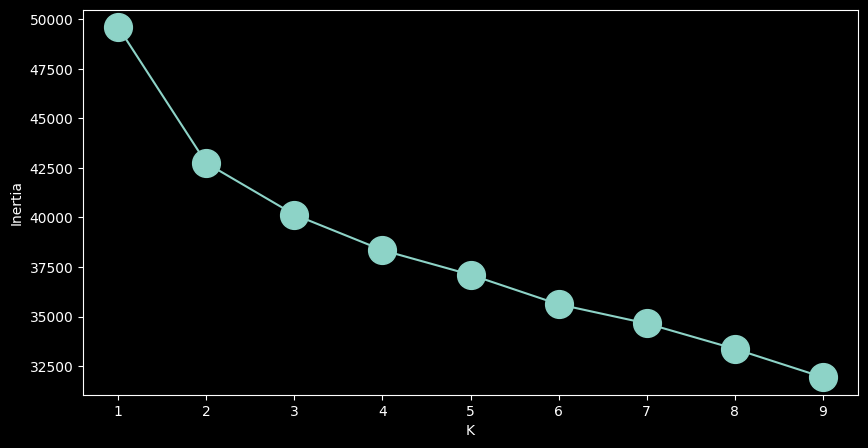

In [235]:
dataframe = DF_Scaled[num_columns]
X = dataframe.values

sse = [] # здесь будем хранить инерции для конкретных к
list_k = list(range(1, 10))
for k in list_k: # тестируем различные к в диапазоне от 1 до 10
    km = KMeans(n_clusters=k, # создаем объект кластеризации с заданным к
            n_init = 10)
    km.fit(X) # обучаем
    sse.append(km.inertia_) # фиксируем текущую инерцию

# визуализируем метод локтя

plt.figure(figsize=(10, 5))
plt.plot(list_k, sse, '-o', markersize = 20)
plt.xlabel('K')
plt.ylabel('Inertia');

Похоже, что либо 2 либо 3 кластера нужно

# Применим кластеризацию K-Means

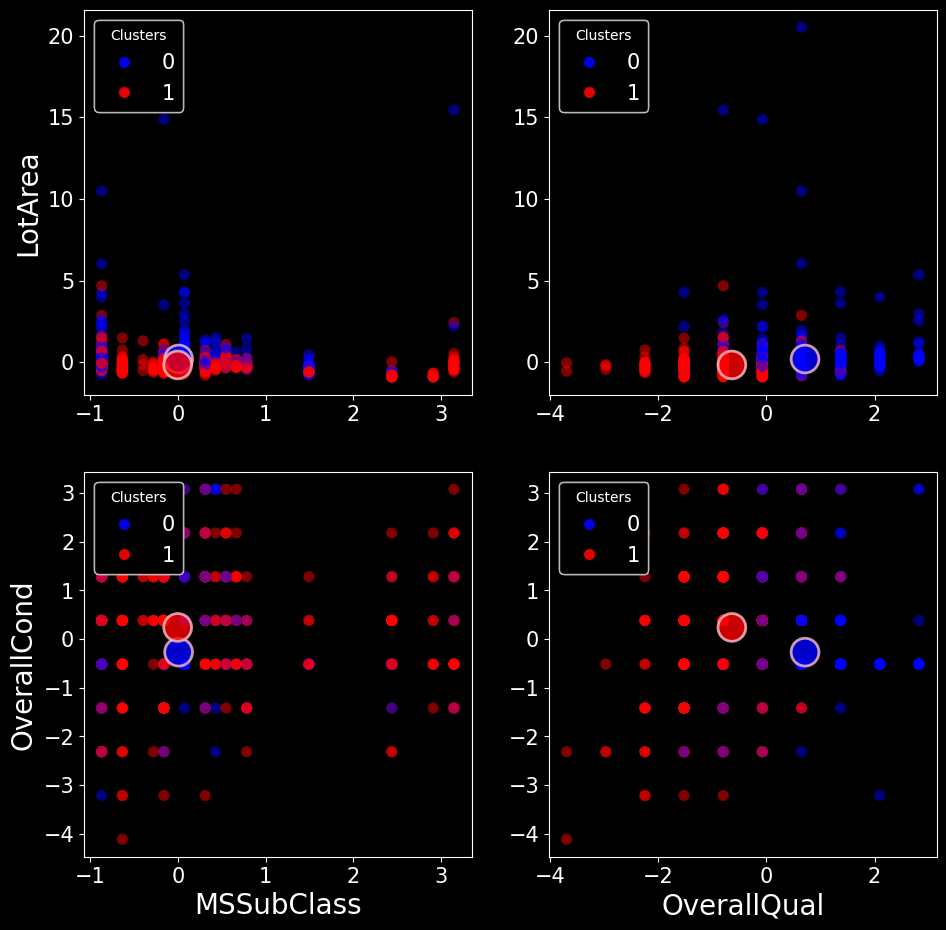

In [236]:
dataframe = DF_Scaled[num_columns]
k = 2

X = dataframe.values

km = KMeans(n_clusters=k,
            n_init = 10)

km.fit(X)
labels = km.predict(X)
centroids = km.cluster_centers_
label_centroids = km.predict(centroids)

fig, sub = plt.subplots(2, 2, figsize = (11,11))
plot_multi(X, labels,
           dataframe.columns,
           sub, size = 64);

plot_multi(centroids, label_centroids,
           dataframe.columns,
           sub,
           alpha = 0.8,
           size = 400,
           edgecolors = 'pink');

По графикам LotArea/MSSubClass и OverallCond/MSSubClass можно предположить, что стоит опробовать клестеризовать по трем кластерам

# Коэффициент Силуэта для результатов кластеризации

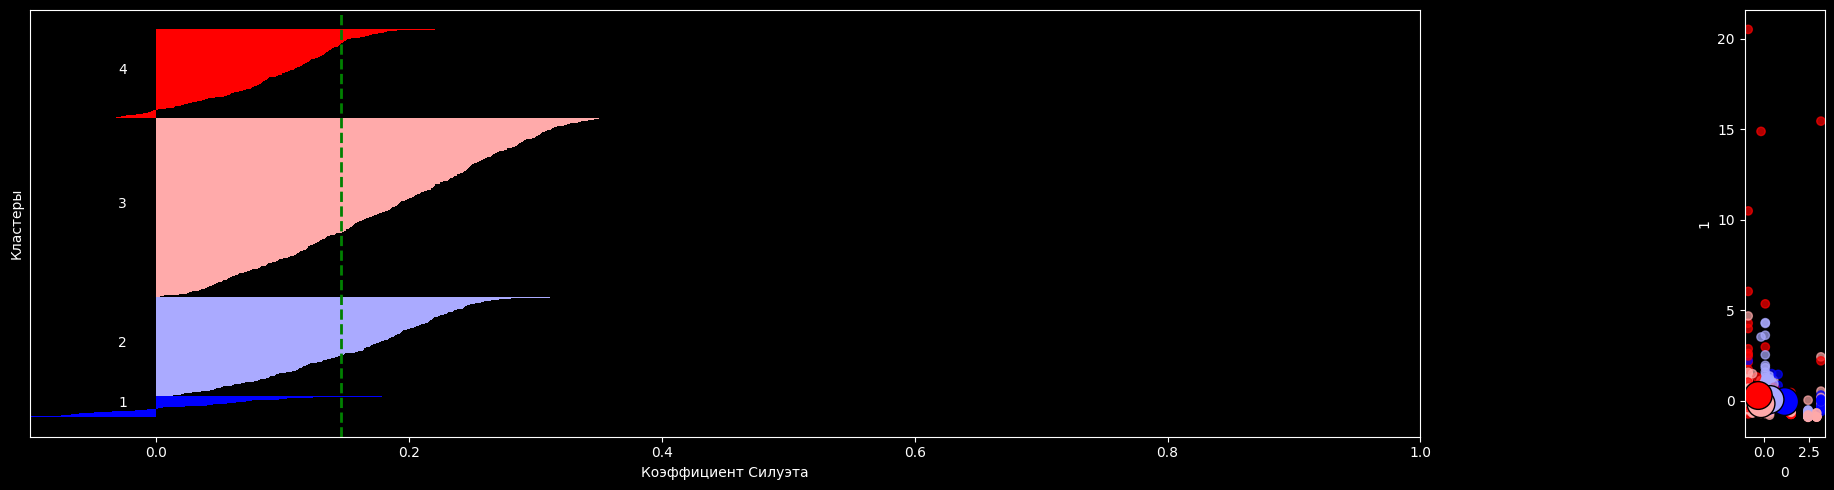

In [237]:
dataframe = DF_Scaled[num_columns]
#@markdown ### Число кластеров
k = 4 #@param {type:"slider", min:2, max:10, step:1}
#@markdown ### Оси для отрисовки
#@markdown ### Ось x
axis_x = 0 #@param {type:"slider", min:0, max:3, step:1}
#@markdown ### Ось y
axis_y = 1 #@param {type:"slider", min:0, max:3, step:1}

X = dataframe.values
# создаем объект
km = KMeans(n_clusters=k,
            n_init = 10)
# обучаем на данных
km.fit(X)
# предсказываем метки кластеров для данных
labels = km.predict(X)
# "забираем" координаты центров
centroids = km.cluster_centers_
# предсказываем метки для центроидов
label_centroids = km.predict(centroids)
# Визуализация и данных, и коэффициентов силуэта
plot_silhouette_results(X,centroids,
                        labels, label_centroids,
                        axis_x, axis_y)

И вправду, попробуем 3

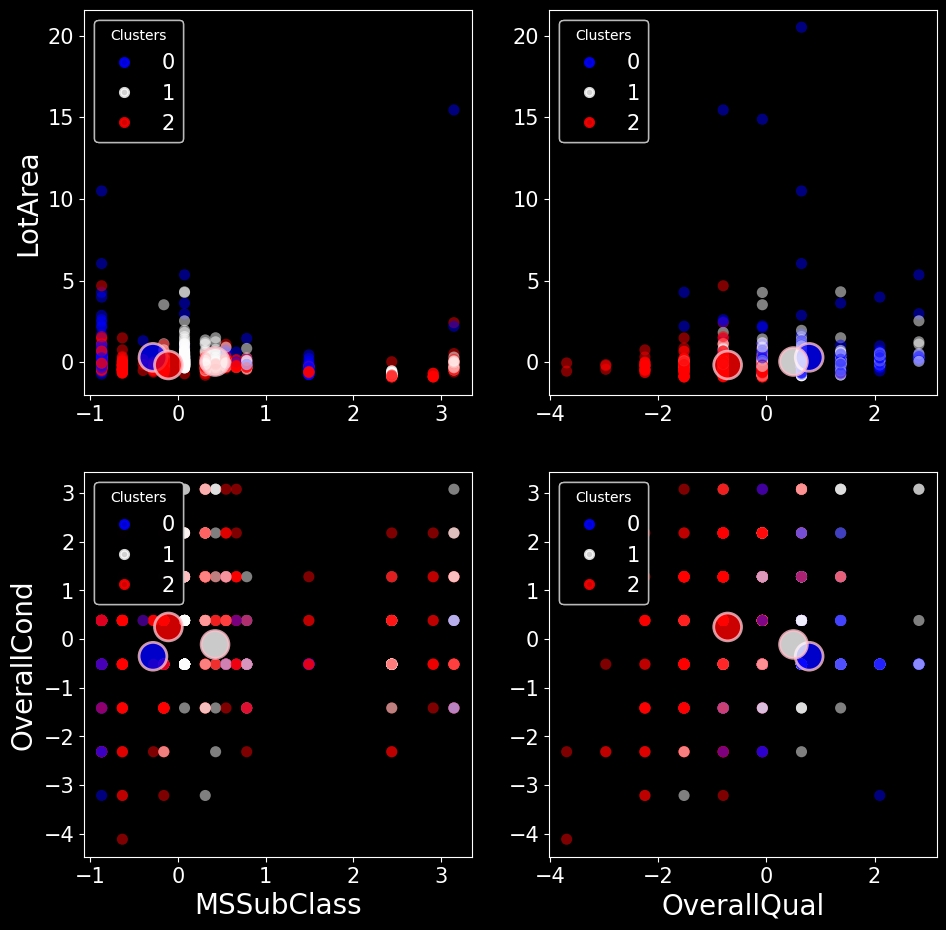

In [238]:
dataframe = DF_Scaled[num_columns]
k = 3

X = dataframe.values

km = KMeans(n_clusters=k,
            n_init = 10)

km.fit(X)
labels = km.predict(X)
centroids = km.cluster_centers_
label_centroids = km.predict(centroids)

fig, sub = plt.subplots(2, 2, figsize = (11,11))
plot_multi(X, labels,
           dataframe.columns,
           sub, size = 64);

plot_multi(centroids, label_centroids,
           dataframe.columns,
           sub,
           alpha = 0.8,
           size = 400,
           edgecolors = 'pink');

Мы остановились на итерации: 7


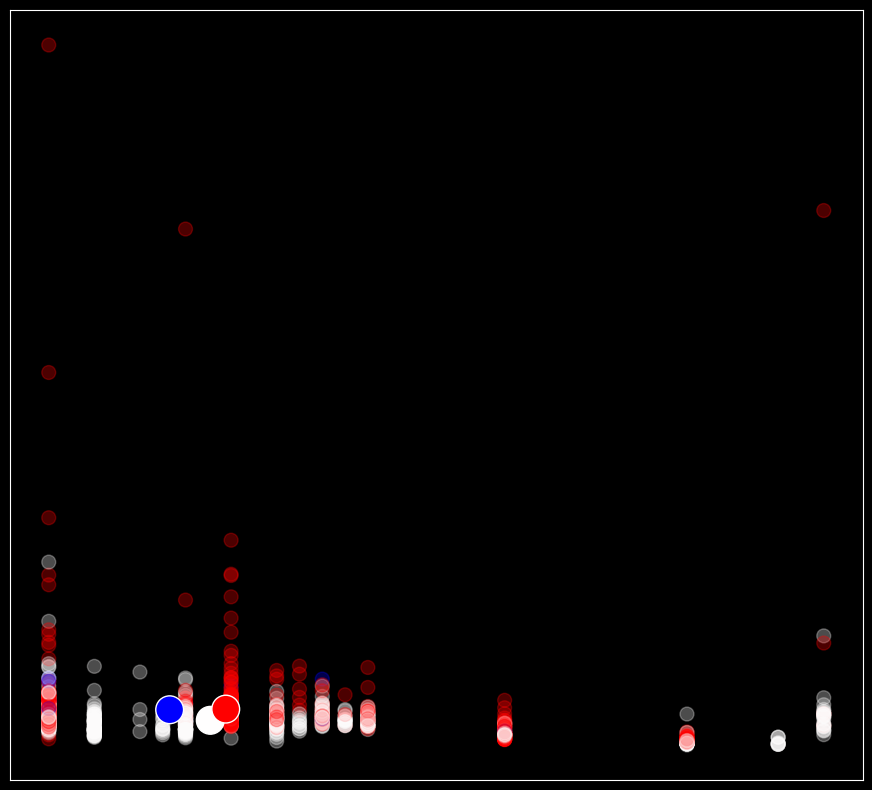

In [239]:
kmeans = KMeans(n_clusters=3, max_iter=100, tol=0.01, random_state=42)

c_labels = kmeans.fit_predict(DF_Scaled[num_columns])

centroids = kmeans.cluster_centers_
centroids_labels = np.arange(len(centroids))

print('Мы остановились на итерации:', kmeans.n_iter_)

plot_cluster(
    np.array(DF_Scaled),
    centroids,
    c_labels,
    centroids_labels
)

Возможно выглядит неважно, но оставляем так. Добро

# Оценим связь кластеров с категориальными признаками

In [240]:
c_labels = kmeans.fit_predict(DF_Scaled[num_columns])
cross_tab = pd.crosstab(DF_Scaled['LotConfig'], c_labels, rownames=['Метки'], colnames=['Предсказания'])
cross_tab

Предсказания,0,1,2
Метки,,,
Corner,3,142,118
CulDSac,4,31,59
FR2,2,20,25
FR3,0,1,3
Inside,14,557,481


Посмотрев на связь кластеров и категориальных признаков у целевой переменной можно сказать, что 1 и 2 кластер очень сильно похожи  между собой, так как связаны с одними и теми же метками (Corner, Inside), а вот 0 кластер будто ни с одной меткой не связан нормально

Посмотрим для других категориальных признаков 'Street', 'Utilities', 'RoofStyle', 'Condition1'

In [241]:
cross_tab = pd.crosstab(DF_Scaled['Street'], c_labels, rownames=['Метки'], colnames=['Предсказания'])
cross_tab

Предсказания,0,1,2
Метки,,,
Grvl,0,4,2
Pave,23,747,684


In [242]:
cross_tab = pd.crosstab(DF_Scaled['Utilities'], c_labels, rownames=['Метки'], colnames=['Предсказания'])
cross_tab

Предсказания,0,1,2
Метки,,,
AllPub,23,750,686
NoSeWa,0,1,0


In [243]:
cross_tab = pd.crosstab(DF_Scaled['RoofStyle'], c_labels, rownames=['Метки'], colnames=['Предсказания'])
cross_tab

Предсказания,0,1,2
Метки,,,
Flat,1,6,6
Gable,15,601,525
Gambrel,0,9,2
Hip,7,130,149
Mansard,0,4,3
Shed,0,1,1


In [244]:
cross_tab = pd.crosstab(DF_Scaled['Condition1'], c_labels, rownames=['Метки'], colnames=['Предсказания'])
cross_tab

Предсказания,0,1,2
Метки,,,
Artery,1,42,5
Feedr,1,59,21
Norm,17,624,619
PosA,0,0,8
PosN,2,5,12
RRAe,0,9,2
RRAn,0,10,16
RRNe,1,0,1
RRNn,1,2,2


для всех признаков выше вывод такой же, разве что метки другие

# Добавим в оригинальный набор данных признаки связанные с результатом кластеризации

Добавляем признаки связанные с кластером

In [245]:
DF_cluster = pd.DataFrame(km.transform(DF_Scaled[num_columns]))
DF_cluster['cluster'] = km.predict(DF_Scaled[num_columns])
DF_cluster

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


,0,1,2,cluster
0,4.883107,3.319089,5.212168,1
1,5.991695,6.534918,5.895047,2
2,4.124275,2.715093,4.943776,1
3,7.135930,6.476144,6.171981,2
4,5.021661,3.759849,7.253634,1
...,...,...,...,...
1455,4.383169,2.621572,4.490382,1
1456,4.365769,6.026014,6.477481,0
1457,8.484635,7.422325,8.546597,1
1458,8.812580,9.238193,7.380307,2


Преобразуем числовые признаки в виде расстояния до центров кластеров

In [246]:
# Создаем копию для числовых признаков
distance_features = DF_cluster.iloc[:, :-1]  # Все столбцы, кроме 'cluster'
scaler = StandardScaler()

# Масштабируем расстояния
distance_scaled = scaler.fit_transform(distance_features)

# Преобразуем обратно в DataFrame
distance_scaled_df = pd.DataFrame(distance_scaled, columns=[f'Distance_to_Cluster_{i}' for i in range(distance_features.shape[1])])

# Обновляем DataFrame с обработанными расстояниями
DF_cluster = pd.concat([distance_scaled_df, DF_cluster[['cluster']]], axis=1)

Добавляем обработанные признаки к исходным данным

In [247]:
DF_Scaled = pd.concat([DF_Scaled, DF_cluster], axis=1)

# Сравним с результатами "Домашняя работа 3"

Попробуем обучить нашу модель с помощью логистической регрессии на преобразованных данных

In [248]:
# Целевая переменная
target = 'LotConfig'  # Замените на название вашей целевой переменной
X = DF_Scaled[num_columns]  # Все признаки, кроме целевой
y = DF_Scaled[target]

# Разделение данных
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Масштабирование (если требуется)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [249]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Создаем пайплайн с логистической регрессией
model = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Масштабирование данных
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])

# Обучение модели
model.fit(X_train_scaled, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=1000, random_state=42))])

In [250]:
from sklearn.metrics import f1_score, classification_report

# Функция для расчета метрики
def calculate_metric(model_pipe, X, y, metric=f1_score, average='weighted'):
    y_model = model_pipe.predict(X)
    return metric(y, y_model, average=average)

# Оценка модели
print(f"F1 на тренировочной выборке: {calculate_metric(model, X_train_scaled, y_train):.4f}")
print(f"F1 на валидационной выборке: {calculate_metric(model, X_val_scaled, y_val):.4f}")
print("\nОтчет по классификации на валидационной выборке:")
print(classification_report(y_val, model.predict(X_val_scaled)))

F1 на тренировочной выборке: 0.6187
F1 на валидационной выборке: 0.6047

Отчет по классификации на валидационной выборке:
              precision    recall  f1-score   support

      Corner       0.17      0.02      0.03        53
     CulDSac       0.00      0.00      0.00        19
         FR2       0.00      0.00      0.00         9
         FR3       0.00      0.00      0.00         1
      Inside       0.72      0.98      0.83       210

    accuracy                           0.71       292
   macro avg       0.18      0.20      0.17       292
weighted avg       0.55      0.71      0.60       292



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Ниже приведен скрин оценки метрик из той работы:

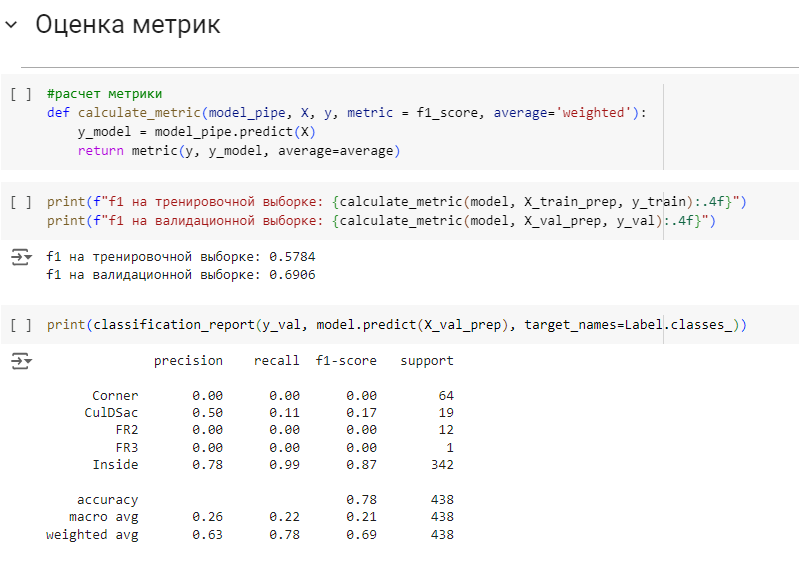

На тренировочной выборке мера F1 чуть выше у модели с кластеризацией, однако на валидационной она проигрывает.

Метрики Precission и Recall улучшились у отдельных классов и ухудшились на других.

В целом, сравнивая эти метрики, можно сказать, что наша модель сейчас работает хуже, чем было до.

# Выводы

Не могу сказать, что получилось идеально кластеризировать данные. Первый и второй кластеры связаны с некоторыми метками в классах, а вот нулевой кластер почти никак не был связан с ними. В теории, новые признаки должны помочь в задаче классификации, но почему то сделали хуже.